In [283]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt


In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv("https://math.ucla.edu/~dmenezes/stochastic_modeling_option_data.csv")

In [193]:
import warnings
warnings.filterwarnings("ignore")

# Step 1

:For calibrating a classic Heston (1993) model to the observed prices for both call and put options, we need to get the options data and calibrate parameters.  We assume a constant risk-free rate of 1.5 per cent per annum.  We also need the current value of the underlying which is $232.90 (United States dollars).  

We use market prices for call and put options to estimate the parameter values for the Heston model.

To calibrate a Heston model, we need to estimate the parameters that best fit the model to observed market prices of options on the asset. The main parameters we need to find are:

* The long-term mean level of volatility
* The volatility of the volatility, which determines how rapidly volatility moves around
* The rate at which volatility reverts to its mean level
* The correlation between the asset price and volatility processes

The basic steps are:

* Get market data on current option prices for a range of strikes and maturities
* Make an initial guess at parameter values for the Heston model
* Use the model with those parameters to calculate theoretical option prices
* Compare the model prices to the market prices and compute the pricing errors
    Adjust the parameters and repeat steps 3-4 until the model prices closely match market prices
    The best fit parameters are the ones that minimize the overall pricing errors across all the options


In contrast with the Black-Scholes model, the Heston model allows for stochastic volatility, meaning that volatility itself is modeled as a random process. It assumes that the underlying asset's volatility follows a square-root diffusion process, known as a stochastic volatility process. This allows the model to capture the observed volatility clustering and mean-reversion properties commonly seen in financial markets.

The stock price satisfies:

$dS_t = \mu S_t\,dt + \sqrt{\nu_t} S_t\,dW^S_t$

and the volatility satisfies

$d\nu_t = \kappa(\theta - \nu_t)\,dt + \sigma \sqrt{\nu_t}\,dW^{\nu}_t$

Here:
* $\nu_0$ is the initial variance
* $\kappa$ is the rate at which $\nu$ reverts to the mean
* $\theta$ is the long-run variance
* $W^S_t$ and $W^\nu_t$ are Wiener processes whose correlation is $\rho$
* $\sigma$ is the volatility of volatility


In [ ]:
S0 = 232.90 # The SM Stonk is currently trading at $232.90 (USD)

In [ ]:
r = 1.50 / 100 # Consider a constant annual risk-free rate of 1.5 per cent per annum

In [ ]:
days_per_year = 250

To calibrate the Heston model we look at calls and puts with 15 days to maturity.


In [ ]:
options = df[df["Days to maturity"] == 15]

The price of the call option is the discounted value of the expected payoff.  However, under the Heston model there is not a closed form for the density of a final value for the stock; hence we need to work in Fourier space.

To calculate the value of a European call option using the Lewis method, we compute the following integral, using numerical integration.

$$C_0= S_0 − {\sqrt{S_0K} e^{-rT} \over \pi} \int_0^\infty \Re[e^{izk}\phi(z − i/2)] {dz \over z^2 + 1/4}$$

here $\phi$ is the characteristic function of the European call option in the Heston model.



In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 -+ c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

To perform calibration, we use the functions we have written to value various puts and calls; we find the values of the parameters that minimize the mean squared error when comparing the computed value with the market data.

In [ ]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0 or v0 < 0.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
      else:
        model_value = model_value = H93_put_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

To calculate the value of calls under the Lewis approach, we perform numerical quadrature; we created Python functions for the characterstic function and the integrand; we can then create another Python function that uses numpy's `quad` function to calculate the value of the integral numerically.

In [ ]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=1000,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

To calculate the value of European put options under the Lewis (2001) approach we use the call values and apply put-call parity:
${\rm Call Price} + Ke^{-rT} = {\rm Put Price} + S_0$

In [ ]:
def H93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European put option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    call_value = H93_call_value(S0,K,T,r,kappa_v, theta_v, sigma_v, rho, v0)
    bond_price = K * np.exp(-r*T)
    return call_value + bond_price - S0

Alternatively we can use the Fast Fourier Transform approach described by Car-Madan (1999) to calculate prices and calibrate the model.

The call price can be found using the following integral:
$$ {\exp(-\alpha k) \over \pi} \int_0^\infty e^{-ivk} \psi(v) dv $$

where

$$\psi(v) = { e^{-rT} \phi(v - (\alpha + i) i) \over  \alpha^2 + \alpha - v^2 + (2\alpha + 1) v i }$$

The above integral can be recognized as a Fourier Transform, so we can approximate it using the Discerte Fourier Transfor

In [ ]:
def H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Call option price in Heston (1993) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

We can compute the put prices using put-call parity.

${\rm Call Price} + Ke^{-rT} = {\rm Put Price} + S_0$



In [ ]:
def H93_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Put option price in Heston (1993) under FFT
    """
    call_price = H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    bond_price = K * np.exp(-T * r)
    return call_price + bond_price - S0

We use an optimization method included with numpy to find the values for the parameters involved in the Heston model that will let us most closely approximate the difference between the calculated prices and the market prices.

In [ ]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

In [ ]:
global i
i=0
min_MSE=500
h93_params = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  16.612 |  16.612
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  10.548 |   7.122
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |   6.927 |   6.887
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  15.576 |   6.657
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |   9.895 |   6.434
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |   6.484 |   6.434
 150 | [ 7.5   0.01  0.15 -0.25  0.01] |  16.651 |   6.434
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  10.558 |   6.434
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |   7.358 |   6.434
 225 | [7.5  0.03 0.15 0.   0.01] |  13.935 |   6.434
 250 | [7.5  0.04 0.05 0.   0.02] |   8.856 |   6.063
 275 | [7.5  0.04 0.25 0.   0.03] |   6.127 |   6.063
 300 | [ 7.10037179  0.05742843  0.03760827 -0.46596154  0.04611934] |   2.505 |   2.505
 325 | [5.10263100e+00 1.01254224e-01 4.93650879e-03 3.68580639e-01
 8.66304257e-02] |   0.058 |   0.035
 350 | [5.58361426 0.09659365 0.00907296 0.32091804 0.08230265] |   0.035 |   0.035
 375 | [5.5850494  0.09696203

<ipython-input-172-7ee6a85e7769>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


 475 | [8.29144162e+00 8.56030180e-02 3.16741581e-04 2.38559822e-01
 8.43910209e-02] |   0.035 |   0.035
 500 | [8.35720227e+00 8.52890871e-02 1.35328403e-05 2.34629208e-01
 8.44557305e-02] |   0.035 |   0.035
 525 | [8.37218869e+00 8.52292697e-02 4.64132800e-06 2.34442657e-01
 8.44514214e-02] |   0.035 |   0.035
 550 | [8.37277472e+00 8.52266200e-02 5.42278934e-06 2.34437554e-01
 8.44509274e-02] |   0.035 |   0.035
 575 | [8.37266035e+00 8.52271451e-02 5.26185885e-06 2.34438606e-01
 8.44510368e-02] |   0.035 |   0.035
 600 | [8.37266653e+00 8.52271369e-02 5.25213787e-06 2.34438818e-01
 8.44510397e-02] |   0.035 |   0.035
 625 | [8.37264857e+00 8.52272192e-02 5.25734211e-06 2.34439235e-01
 8.44510484e-02] |   0.035 |   0.035
 650 | [8.37264633e+00 8.52272291e-02 5.25882701e-06 2.34439285e-01
 8.44510492e-02] |   0.035 |   0.035
 675 | [8.37264621e+00 8.52272295e-02 5.25891670e-06 2.34439286e-01
 8.44510492e-02] |   0.035 |   0.035
 700 | [8.37264613e+00 8.52272299e-02 5.25895022e-06 2.

We obtain the following values after performing the optimization procedure

* $\kappa_v = 8.37264613$
* $\theta_v = 0.085227229$
* $\sigma_v = 5.25896320 \times 10^{-6}$
* $\rho = 0.234439288$
* $v_0 =   0.0844510492$


Now we can define the error function so that we can perform the same optimization for the Carr-Madan (1999) pricing approach.

In [ ]:
def H93_error_function_FFT(p0):
    """Error function for parameter calibration via
    Carr-Madan (1999) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0 or v0 < 0.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
        model_value = H93_call_FFT(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
      else:
        model_value = model_value = H93_put_FFT(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def H93_calibration_full_FFT():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function_FFT, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

In [ ]:
global i
i=0
min_MSE=500
h93_params_FFT = H93_calibration_full_FFT()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  16.612 |  16.612
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  10.548 |   7.122
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |   6.927 |   6.887
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  15.576 |   6.657
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |   9.895 |   6.434
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |   6.484 |   6.434
 150 | [ 7.5   0.01  0.15 -0.25  0.01] |  16.651 |   6.434
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  10.558 |   6.434
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |   7.358 |   6.434
 225 | [7.5  0.03 0.15 0.   0.01] |  13.935 |   6.434
 250 | [7.5  0.04 0.05 0.   0.02] |   8.856 |   6.063
 275 | [7.5  0.04 0.25 0.   0.03] |   6.127 |   6.063
 300 | [ 7.10037179  0.05742843  0.03760827 -0.46596154  0.04611934] |   2.505 |   2.505
 325 | [5.10263100e+00 1.01254224e-01 4.93650879e-03 3.68580639e-01
 8.66304257e-02] |   0.058 |   0.035
 350 | [5.58361426 0.09659365 0.00907296 0.32091804 0.08230265] |   0.035 |   0.035
 375 | [5.5850494  0.09696203

Under the Carr-Lewis approach we obtain the following values for the
    
* $\kappa_v = 8.3501410 $
* $\theta_v = 0.0852981024$
* $\sigma_v = 7.1987057 \times 10^{-6} $
* $\rho =  0.0234147455 $
* $v_0 = 0.0844535023$

These values are similar to those obtained using the Lewis approach.

In [ ]:
options_lewis = options.copy()
options_carr = options.copy()

In [ ]:
kappa_v, theta_v, sigma_v, rho, v0 = h93_params
options_lewis["Model"] = 0.0
for row, option in options_lewis.iterrows():
      if option["Type"] == "C":
        options_lewis.loc[row, "Model"] = H93_call_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
      else:
        options_lewis.loc[row, "Model"] = model_value = H93_put_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )

<ipython-input-172-7ee6a85e7769>:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


In [ ]:
options_lewis

,Days to maturity,Strike,Price,Type,Model
0,15,227.5,10.52,C,9.720195
1,15,230.0,10.05,C,8.244728
2,15,232.5,7.75,C,6.919611
3,15,235.0,6.01,C,5.744201
4,15,237.5,4.75,C,4.715860
15,15,227.5,4.32,P,4.115537
16,15,230.0,5.20,P,5.137821
17,15,232.5,6.45,P,6.310455
18,15,235.0,7.56,P,7.632796
19,15,237.5,8.78,P,9.102206


Text(0.5, 0, 'Strike Price')

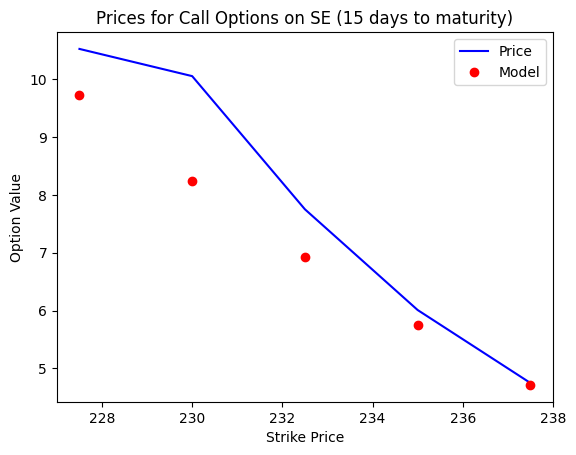

In [ ]:
options_lewis.set_index("Strike", inplace=True)
options_lewis[options_lewis["Type"] == "C"][["Price", "Model"]].plot(
            style=["b-", "ro"], title="Prices for Call Options on SE (15 days to maturity)")
plt.ylabel("Option Value")
plt.xlabel("Strike Price")


Text(0.5, 0, 'Strike Price')

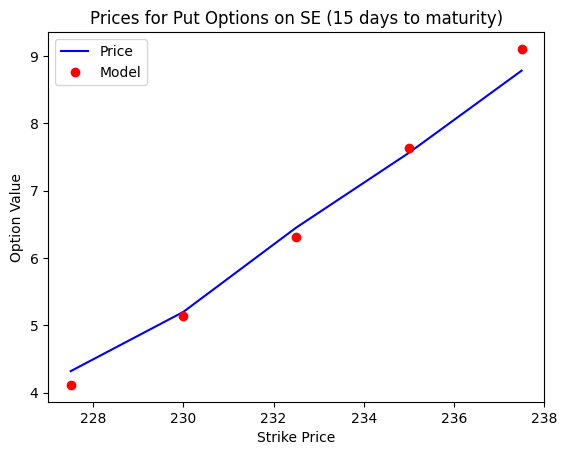

In [ ]:
options_lewis[options_lewis["Type"] == "P"][["Price", "Model"]].plot(
            style=["b-", "ro"], title="Prices for Put Options on SE (15 days to maturity)")
plt.ylabel("Option Value")
plt.xlabel("Strike Price")


Looking at the plot shows that we get  good results using the Lewis method.


In [ ]:
kappa_v, theta_v, sigma_v, rho, v0 = h93_params_FFT
options_carr["Model"] = 0.0
for row, option in options_carr.iterrows():
      if option["Type"] == "C":
        options_carr.loc[row, "Model"] = H93_call_FFT(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
      else:
        options_carr.loc[row, "Model"] = model_value = H93_put_FFT(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )

In [ ]:
options_carr

,Days to maturity,Strike,Price,Type,Model
0,15,227.5,10.52,C,9.720626
1,15,230.0,10.05,C,8.245391
2,15,232.5,7.75,C,6.920094
3,15,235.0,6.01,C,5.744874
4,15,237.5,4.75,C,4.716517
15,15,227.5,4.32,P,4.115968
16,15,230.0,5.20,P,5.138484
17,15,232.5,6.45,P,6.310939
18,15,235.0,7.56,P,7.633469
19,15,237.5,8.78,P,9.102863


Text(0.5, 0, 'Strike Price')

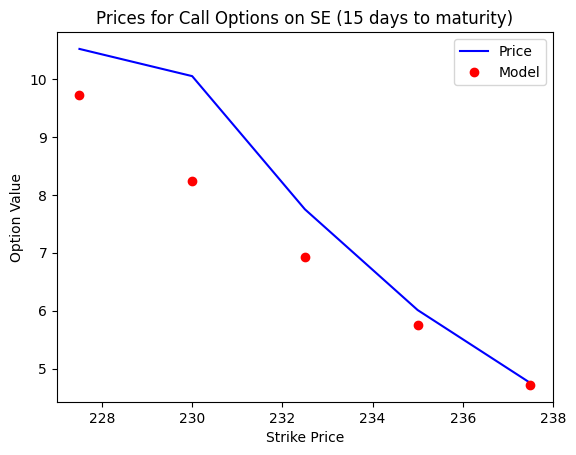

In [ ]:
options_carr.set_index("Strike", inplace=True)
options_carr[options_carr["Type"] == "C"][["Price", "Model"]].plot(
            style=["b-", "ro"], title="Prices for Call Options on SE (15 days to maturity)")
plt.ylabel("Option Value")
plt.xlabel("Strike Price")


Text(0.5, 0, 'Strike Price')

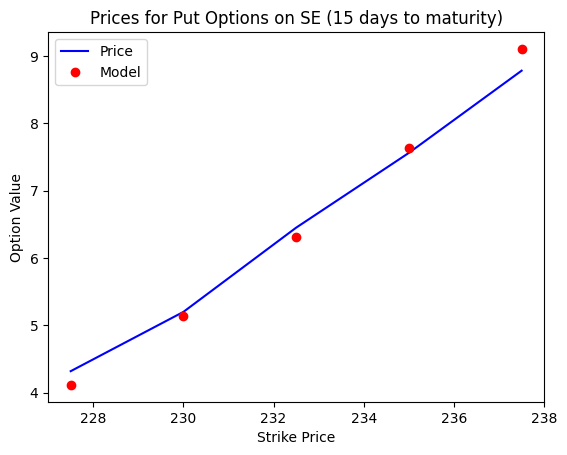

In [ ]:
options_carr[options_carr["Type"] == "P"][["Price", "Model"]].plot(
            style=["b-", "ro"], title="Prices for Put Options on SE (15 days to maturity)")
plt.ylabel("Option Value")
plt.xlabel("Strike Price")

We also get good results using the Carr-Madan method.

## Pricing an Asian option

We use Monte-Carlo simulation in a Heston model to price At-the-Money Asian call and put options.  We use the parameter values obtained during the calibration phase.

To do this, we create a function `generate_heston_paths' that uses the NumPy library to generate paths for the Heston stochastic volatility model. It iterates over a specified number of steps to simulate asset price and volatility paths based on the Heston model dynamics. The function returns an array of asset price paths, and optionally, an array of volatility paths if specified. By leveraging NumPy's vectorized computations, the code efficiently generates paths for the Heston model, making it suitable for financial applications involving stochastic volatility analysis.

In [ ]:
import numpy as np
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma,
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]),
                                           cov = np.array([[1,rho],
                                                          [rho,1]]),
                                           size=Npaths) * np.sqrt(dt)

        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) )
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + sigma*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t

    if return_vol:
        return prices, sigs

    return prices

In [ ]:
np.random.seed(42)


We begin by generating a large number of paths under the Heston model with the given values.

In [ ]:
kappa, theta, sigma, rho, v0 = h93_params_FFT
heston_paths = generate_heston_paths(S0, 20/365, 0.0150, kappa, theta, v0, rho, sigma, 90, 20000)

We can then compute the payoffs at maturity

$\max \left({\rm Avg}({S_t}) - K, 0\right)$ for a call and

$\max \left(K - {\rm Avg}({S_t}), 0\right)$ for a put

In [ ]:
heston_payoffs =  np.maximum(np.mean(heston_paths, axis=1) - S0, 0)

To compute the fair value of the Asian option, we take the average across all paths, and discount by the risk-free rate of 1.5 per cent per annum (applied over the 20 day maturity period).

In [ ]:
print(f"The price of an ATM Asian call option with 20 days maturity is {np.exp(-r * (20/days_per_year)) * np.mean(heston_payoffs):.4f}")

The price of an ATM Asian call option with 20 days maturity is 3.7680


In [ ]:
heston_put_payoffs = np.maximum(S0 - np.mean(heston_paths, axis=1), 0)

In [ ]:
print(f"The price of an ATM Asian put option with 20 days maturity is {np.exp(-r * (20/days_per_year)) * np.mean(heston_put_payoffs):.4f}")

The price of an ATM Asian put option with 20 days maturity is 3.5871


If we add a 4% fee onto the fair price for the ATM Asian call, we get a final price of $3.91

If we add a 4% fee onto the fair price for the ATM Asian put, we get a final price of $3.73

# Step 2

We can perform the same calibration procedure but using the Bates model.  For the Lewis method, we again calculate a similar integral, but for the Bates method characteristic function, which is the product of the Heston and Merton characteristic functions.

To calculate the option values under the Bates model, we need the various characteristic functions

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

We can then compute the value using the Lewis method by numerical integration.

In [ ]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

To calculate the put value, we use put-call parity

In [ ]:
def B96_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
  call_value = B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
  bond_value = K * np.exp(-T * r)
  return call_value + bond_value - S0

We can also calculate values using the FFT method described in Carr-Madan.

In [ ]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

Again, getting the values for put options requires using put-call parity.

In [ ]:
def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
  call_value = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
  bond_value = K * np.exp(-r * T)
  return call_value + bond_value - S0

To perform calibration, we need to extract the options with 60 days to maturity.

In [292]:
options = df[((df["Days to maturity"] == 60))]
options_lewis = options.copy()
options_carr = options.copy()

In [242]:
options

,Days to maturity,Strike,Price,Type
5,60,227.5,16.78,C
6,60,230.0,17.65,C
7,60,232.5,16.86,C
8,60,235.0,16.05,C
9,60,237.5,15.10,C
20,60,227.5,11.03,P
21,60,230.0,12.15,P
22,60,232.5,13.37,P
23,60,235.0,14.75,P
24,60,237.5,15.62,P


We start by calibrating a Heston model to the marked data. That is, we calculate the option prices for various parameter values using the Lewis method, and determine what parameter values get us closest to market prices.

In [243]:
global i
i=0
min_MSE=500
h93_params_bates = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  85.000 |  85.000
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  54.937 |  44.467
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  41.211 |  40.055
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  68.594 |  36.047
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  44.634 |  32.394
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |  33.371 |  32.394
 150 | [ 7.5   0.01  0.15 -0.25  0.01] |  85.452 |  32.394
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  54.972 |  32.394
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  45.920 |  32.394
 225 | [7.5  0.03 0.15 0.   0.01] |  53.566 |  32.394
 250 | [7.5  0.04 0.05 0.   0.02] |  34.954 |  28.535
 275 | [7.5  0.04 0.25 0.   0.03] |  28.992 |  28.535
 300 | [ 9.21694329  0.06781921  0.03916835 -0.50229147  0.03442829] |  11.042 |  11.042
 325 | [ 1.28958937e+01  1.20222004e-01  9.21997485e-03 -8.91308956e-02
  4.27971614e-02] |   0.066 |   0.066
 350 | [ 1.25532398e+01  1.16213168e-01  1.12457955e-02 -1.19139006e-01
  4.26928938e-02] |   0.049 |   0.04

In [248]:
h93_params_bates

array([ 1.90743594e+01,  1.20350596e-01,  9.94100834e-02, -9.99999997e-01,
        2.75696654e-10])

In [247]:
h93_params_bates_FFT

array([ 1.90743552e+01,  1.20350566e-01,  9.94100890e-02, -9.99999991e-01,
        4.15852243e-10])

We can also do the Heston calibration using the Carr-Madan method.

In [244]:
global i
i=0
min_MSE=500
h93_params_bates_FFT = H93_calibration_full_FFT()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  85.000 |  85.000
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  54.937 |  44.467
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  41.211 |  40.055
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  68.594 |  36.047
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  44.634 |  32.394
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |  33.371 |  32.394
 150 | [ 7.5   0.01  0.15 -0.25  0.01] |  85.452 |  32.394
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  54.972 |  32.394
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  45.920 |  32.394
 225 | [7.5  0.03 0.15 0.   0.01] |  53.566 |  32.394
 250 | [7.5  0.04 0.05 0.   0.02] |  34.954 |  28.535
 275 | [7.5  0.04 0.25 0.   0.03] |  28.992 |  28.535
 300 | [ 9.21694329  0.06781921  0.03916835 -0.50229147  0.03442829] |  11.042 |  11.042
 325 | [ 1.28958937e+01  1.20222004e-01  9.21997485e-03 -8.91308956e-02
  4.27971614e-02] |   0.066 |   0.066
 350 | [ 1.25532398e+01  1.16213168e-01  1.12457955e-02 -1.19139006e-01
  4.26928938e-02] |   0.049 |   0.04

In [249]:
kappa_v, theta_v, sigma_v, rho, v0 = h93_params_bates
options_lewis["Model"] = 0.0
for row, option in options_lewis.iterrows():
      if option["Type"] == "C":
        options_lewis.loc[row, "Model"] = H93_call_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
      else:
        options_lewis.loc[row, "Model"] = model_value = H93_put_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )

In [250]:
options_lewis

,Days to maturity,Strike,Price,Type,Model
5,60,227.5,16.78,C,17.127132
6,60,230.0,17.65,C,15.801437
7,60,232.5,16.86,C,14.547237
8,60,235.0,16.05,C,13.363939
9,60,237.5,15.10,C,12.250607
20,60,227.5,11.03,P,10.909605
21,60,230.0,12.15,P,12.074925
22,60,232.5,13.37,P,13.311741
23,60,235.0,14.75,P,14.619460
24,60,237.5,15.62,P,15.997144


In [251]:
i = 0
min_MSE = 5000.0
local_opt = False

In [252]:
kappa_v, theta_v, sigma_v, rho, v0 = h93_params_bates_FFT
options_carr["Model"] = 0.0
for row, option in options_carr.iterrows():
      if option["Type"] == "C":
        options_carr.loc[row, "Model"] = H93_call_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
      else:
        options_carr.loc[row, "Model"] = model_value = H93_put_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )

In [253]:
options_carr

,Days to maturity,Strike,Price,Type,Model
5,60,227.5,16.78,C,17.127130
6,60,230.0,17.65,C,15.801435
7,60,232.5,16.86,C,14.547234
8,60,235.0,16.05,C,13.363937
9,60,237.5,15.10,C,12.250605
20,60,227.5,11.03,P,10.909603
21,60,230.0,12.15,P,12.074923
22,60,232.5,13.37,P,13.311739
23,60,235.0,14.75,P,14.619458
24,60,237.5,15.62,P,15.997142


We get a relatively good fit for the option prices using Heston calibration alone.

In [254]:
kappa_v, theta_v, sigma_v, rho, v0 = h93_params_bates
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
          model_value = B96_call_value(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
          se.append((model_value - option["Price"]) ** 2)
      else:
        model_value = B96_put_value(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [255]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    global local_opt, opt1, opt2
    local_opt = False
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )
    local_opt = True
    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

The next step in the calibration is to calculate parameter values for the jump (Merton) component.

Next, we calibrate the jump component of the Bates model; we use the values for $\kappa$, $\theta$, $\sigma$ and $\rho$ from our previous calibration of the Heston model.

We use an optimizer to calculate the values for the parameters $\lambda$, $\mu$, and $\delta$ which minimize the following objective function:


\begin{equation*}
    \min_p \frac{1}{N} \sum_{n=1}^{N} \left( C_n^* - C^{B96}_n(p) \right)^2 + ω \ Penalty (p)
\end{equation*}


 This error function includes a **penalty term** of the form
\
\begin{equation*}
    Penalty \ (p) \equiv \sqrt{(p_0 - p)^2}
\end{equation*}

\
with $p_0$ being the vector of initial parameter values and $p$ the current vector.


In [256]:
i=0
min_MSE = 500
params = B96_calibration_short()

   0 | [ 0.  -0.5  0. ] |   2.440 |   2.440
  25 | [ 0.2  -0.5   0.25] |   2.209 |   1.587
  50 | [ 0.4 -0.5  0.5] |  10.221 |   1.587
  75 | [ 4.0e-01 -2.0e-01  2.5e-04] |   1.582 |   1.582
 100 | [ 3.99869655e-01 -1.99759712e-01  1.28818256e-04] |   1.582 |   1.582
 125 | [ 4.00000568e-01 -1.99984552e-01  9.49259232e-06] |   1.582 |   1.582
 150 | [ 4.00000317e-01 -1.99999129e-01  6.55330370e-07] |   1.582 |   1.582
Optimization terminated successfully.
         Current function value: 1.582206
         Iterations: 70
         Function evaluations: 125


In [257]:
kappa_v, theta_v, sigma_v, rho, v0 = h93_params_bates_FFT
def B96_error_function_FFT(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
          model_value = B96_call_FFT(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
          se.append((model_value - option["Price"]) ** 2)
      else:
        model_value = B96_put_FFT(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [258]:
def B96_calibration_short_FFT():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    global opt1, opt2, local_opt
    local_opt = False
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )
    local_opt = True
    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function_FFT,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [259]:
i=0
min_MSE=5000
params_FFT = B96_calibration_short_FFT()

   0 | [ 0.  -0.5  0. ] |   2.440 |   2.440
  25 | [ 0.2  -0.5   0.25] |   2.209 |   1.587
  50 | [ 0.4 -0.5  0.5] |  10.221 |   1.587
  75 | [ 4.0e-01 -2.0e-01  2.5e-04] |   1.582 |   1.582
 100 | [ 3.99869655e-01 -1.99759712e-01  1.28818256e-04] |   1.582 |   1.582
 125 | [ 4.00000568e-01 -1.99984552e-01  9.49259232e-06] |   1.582 |   1.582
 150 | [ 4.00000317e-01 -1.99999129e-01  6.55330370e-07] |   1.582 |   1.582
Optimization terminated successfully.
         Current function value: 1.582206
         Iterations: 70
         Function evaluations: 125


In [260]:
params

array([ 0.4, -0.2,  0. ])

In [261]:
params_FFT

array([ 0.4, -0.2,  0. ])

We can repeat the process of using the previously calibrated values as inputs for the full calibration of the model.

In this case, our inputs will not only consist on the parameters from the stochastic volatility model ($\kappa_\nu$, $\theta_\nu$, $\sigma_\nu$, $\rho$, $\nu_0$), but also those from the jump component ($λ$, $\mu$, $\delta$).

In [262]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
          model_value = B96_call_value(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
          se.append((model_value - option["Price"]) ** 2)
      else:
        model_value = B96_put_value(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [263]:
lamb, mu, delta = params

p0 =  [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]
p0

[19.074355234361363,
 0.12035056598539409,
 0.09941008896858974,
 -0.9999999912954931,
 4.158522431231629e-10,
 0.4,
 -0.19999999999999996,
 0.0]

In [264]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.0000001, ftol=0.0000001, maxiter=1250, maxfun=650
    )
    return opt

In [265]:
params_bates_full = B96_calibration_full()

   0 | [ 1.90743552e+01  1.20350566e-01  9.94100890e-02 -9.99999991e-01
  4.15852243e-10  4.00000000e-01 -2.00000000e-01  0.00000000e+00] |   1.582 |   1.582
  25 | [ 1.92278935e+01  1.20497334e-01  1.00070317e-01 -9.94042551e-01
  4.23000051e-10  3.99238119e-01 -1.98077343e-01  8.59416730e-05] |   1.581 |   1.578
  50 | [ 2.15086536e+01  1.26380712e-01  7.47939435e-02 -9.35961618e-01
  4.11889346e-10  3.88581301e-01 -1.41902422e-01  1.47326334e-03] |   1.568 |   1.560
  75 | [ 2.45847850e+01  1.28411759e-01  6.03571180e-02 -8.55683432e-01
  3.39893078e-10  4.21909558e-01 -5.88906947e-02  2.30808471e-03] |   1.547 |   1.546
 100 | [ 2.64078196e+01  1.28352550e-01  4.60835962e-02 -8.03256254e-01
  3.43569911e-10  4.73115544e-01 -3.57295516e-03  2.54738792e-03] |   1.544 |   1.543
 125 | [ 2.61690216e+01  1.28032316e-01  2.39210708e-02 -7.96811850e-01
  3.60271070e-10  4.68981887e-01 -7.44900901e-03  3.19069503e-03] |   1.541 |   1.540
 150 | [ 2.50364898e+01  1.28370019e-01  1.16016635e

In [266]:
i = 0
min_MSE = 5000.0


def B96_full_error_function_FFT(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
      if option["Type"] == "C":
          model_value = B96_call_FFT(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
          se.append((model_value - option["Price"]) ** 2)
      else:
        model_value = B96_put_FFT(
              S0,
              option["Strike"],
              option["Days to maturity"] / days_per_year,
              r,
              kappa_v,
              theta_v,
              sigma_v,
              rho,
              v0,
              lamb,
              mu,
              delta,
          )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [267]:
lamb, mu, delta = params_FFT

In [268]:
kappa_v, theta_v, sigma_v, rho, v0 = h93_params_bates_FFT

In [269]:

p0 =  [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]
p0

[19.074355234361363,
 0.12035056598539409,
 0.09941008896858974,
 -0.9999999912954931,
 4.158522431231629e-10,
 0.4,
 -0.19999999999999996,
 0.0]

In [270]:
def B96_calibration_full_FFT():
    opt = fmin(
        B96_full_error_function_FFT, p0, xtol=0.0000001, ftol=0.0000001, maxiter=1250, maxfun=650
    )
    return opt

In [271]:
i=0
params_full_bates_FFT = B96_calibration_full_FFT()

   0 | [ 1.90743552e+01  1.20350566e-01  9.94100890e-02 -9.99999991e-01
  4.15852243e-10  4.00000000e-01 -2.00000000e-01  0.00000000e+00] |   1.582 |   1.582
  25 | [ 1.92278935e+01  1.20497334e-01  1.00070317e-01 -9.94042551e-01
  4.23000051e-10  3.99238119e-01 -1.98077343e-01  8.59416730e-05] |   1.581 |   1.578
  50 | [ 2.15086536e+01  1.26380712e-01  7.47939435e-02 -9.35961618e-01
  4.11889346e-10  3.88581301e-01 -1.41902422e-01  1.47326334e-03] |   1.568 |   1.560
  75 | [ 2.45847850e+01  1.28411759e-01  6.03571180e-02 -8.55683432e-01
  3.39893078e-10  4.21909558e-01 -5.88906947e-02  2.30808471e-03] |   1.547 |   1.546
 100 | [ 2.64078196e+01  1.28352550e-01  4.60835962e-02 -8.03256254e-01
  3.43569911e-10  4.73115544e-01 -3.57295516e-03  2.54738792e-03] |   1.544 |   1.543
 125 | [ 2.61690216e+01  1.28032316e-01  2.39210708e-02 -7.96811850e-01
  3.60271070e-10  4.68981887e-01 -7.44900901e-03  3.19069503e-03] |   1.541 |   1.540
 150 | [ 2.50364898e+01  1.28370019e-01  1.16016635e

We get different values for the estimated parameters using the Lewis and Carr-Madan method.

We can now use the estimated parameters to price our option.

In [293]:
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = params_full_bates_FFT
options_carr["Model"] = 0.0
for row, option in options_carr.iterrows():
      if option["Type"] == "C":
        options_carr.loc[row, "Model"] = B96_call_FFT(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0, lamb, mu, delta
        )
      else:
        options_carr.loc[row, "Model"] = model_value = B96_put_FFT(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0, lamb, mu, delta
        )

Text(0.5, 0, 'Strike Price')

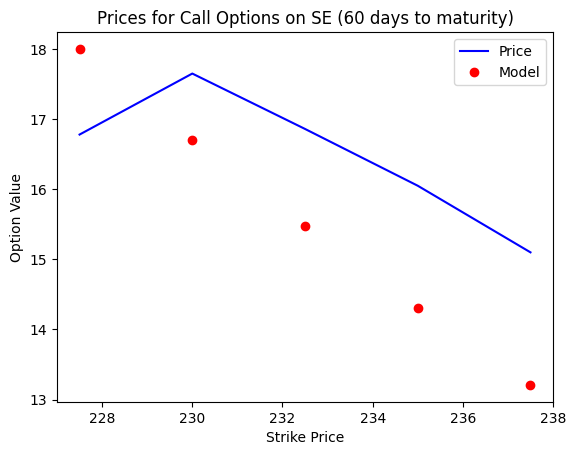

In [294]:
options_carr.set_index("Strike", inplace=True)
options_carr[options_carr["Type"] == "C"][["Price", "Model"]].plot(
            style=["b-", "ro"], title="Prices for Call Options on SE (60 days to maturity)")
plt.ylabel("Option Value")
plt.xlabel("Strike Price")

In [295]:
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = params_bates_full
options_lewis["Model"] = 0.0
for row, option in options_lewis.iterrows():
      if option["Type"] == "C":
        options_lewis.loc[row, "Model"] = B96_call_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0, lamb, mu, delta
        )
      else:
        options_lewis.loc[row, "Model"] = model_value = B96_put_value(
            S0,
            option["Strike"],
            option["Days to maturity"] / days_per_year,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0, lamb, mu, delta
        )


Text(0.5, 0, 'Strike Price')

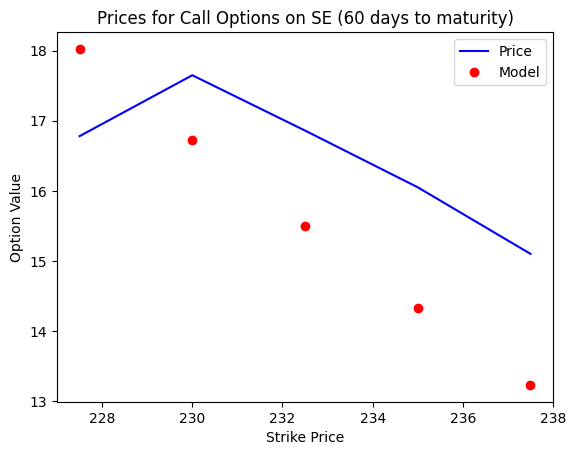

In [297]:
options_lewis.set_index("Strike", inplace=True)
options_lewis[options_lewis["Type"] == "C"][["Price", "Model"]].plot(
            style=["b-", "ro"], title="Prices for Call Options on SE (60 days to maturity)")
plt.ylabel("Option Value")
plt.xlabel("Strike Price")

In [298]:
p = B96_put_FFT( S0,  S0*0.95,               70 / days_per_year,
              r, *params_full_bates_FFT)
print(f"The price of the Put using the Carr-Madan method is {p:.2f}")

The price of the Put using the Carr-Madan method is 10.34


In [299]:
p = B96_put_value( S0,  S0*0.95,               70 / days_per_year,
              r, *params_bates_full)
print(f"The price of the Put using the Lewis method is {p:.2f}")

The price of the Put using the Lewis method is 10.37


After adding 4% for our fee, we get a price of \$10.75 using the Carr-Madan method, or \$10.78 using the Lewis method.



# Step 3

The Cox-Ingersoll-Ross (CIR) model is a popular mathematical model used to describe the behavior of interest rates over time. It was developed by economists John C. Cox, Jonathan E. Ingersoll Jr., and Stephen A. Ross in 1985. The CIR model is a variation of the Vasicek model and is widely used in financial modeling and derivatives pricing.

The CIR model assumes that interest rates follow a mean-reverting process, meaning they tend to move towards a long-term average level. It addresses one of the limitations of the Vasicek model, which allowed for negative interest rates. The CIR model avoids negative interest rates by incorporating a non-negative parameter called the mean reversion level.

The CIR model is defined by the following stochastic differential equation:

$dR(t) = \kappa(\theta - R(t))dt + \sigma \sqrt{R(t)} dW(t)$

where $R(t)$ represents the short-term interest rate at time t, $\kappa$ is the speed of mean reversion, $\theta$ is the mean reversion level, $\sigma$ is the volatility parameter, and $dW(t)$ is a standard Wiener process (a mathematical term for random fluctuations).

To calibrate the CIR model, a list of interest rates with various terms is typically used. The calibration process involves estimating the model parameters ($\kappa$, $\sigma$ and $\theta$) that best fit the observed interest rate data. This is usually done by minimizing the difference between the model-generated interest rates and the observed rates using least squares regression.

In [ ]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

We optimize the parameters by minimizing the mean squared error (MSE). This is, given $\alpha$ equal to the set of parameters to calibrate:

$$
\
\begin{equation*}
  min \frac{1}{M} \sum_{m=0}^{M} \left( f(0,m\Delta t) - f^{CIR}(0,m\Delta t; \alpha) \right)^2
\end{equation*}
$$
\
with $M = T / \Delta t$, that is, the number of market data points between $0$ and $T$.

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [ ]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)

In [ ]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

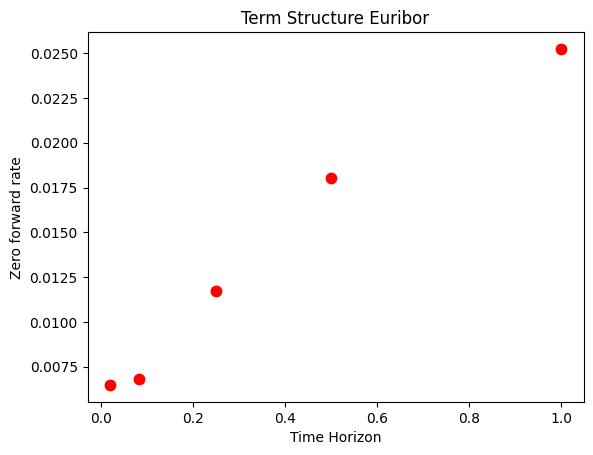

In [ ]:
import matplotlib.pyplot as plt
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

In [ ]:
from scipy.interpolate import splev, splrep

In [ ]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

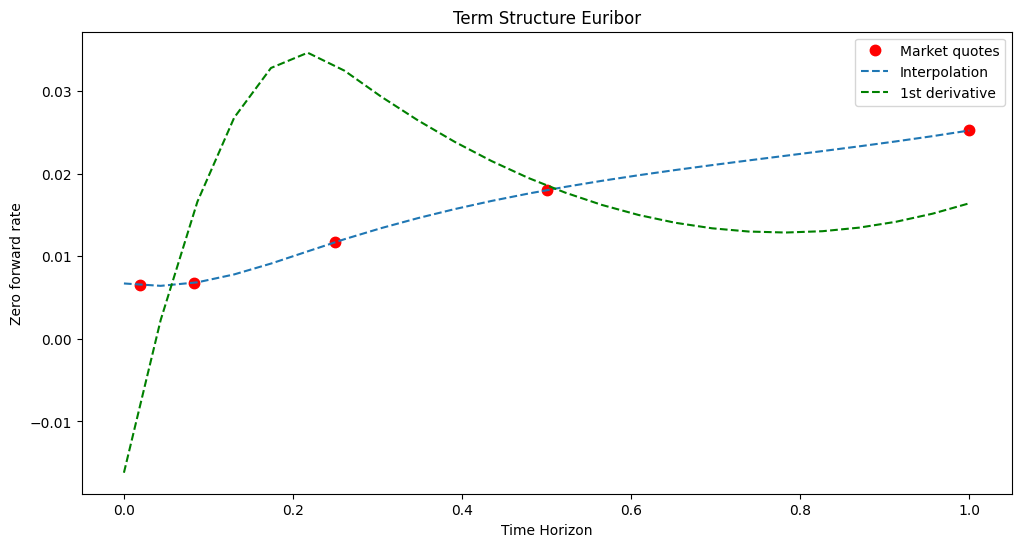

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 161
         Function evaluations: 288


array([0.98908305, 0.10863186, 0.00100074])

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

Now we can plot the predicted forward rates compared with the market forward rates in order to check the fit of the model.

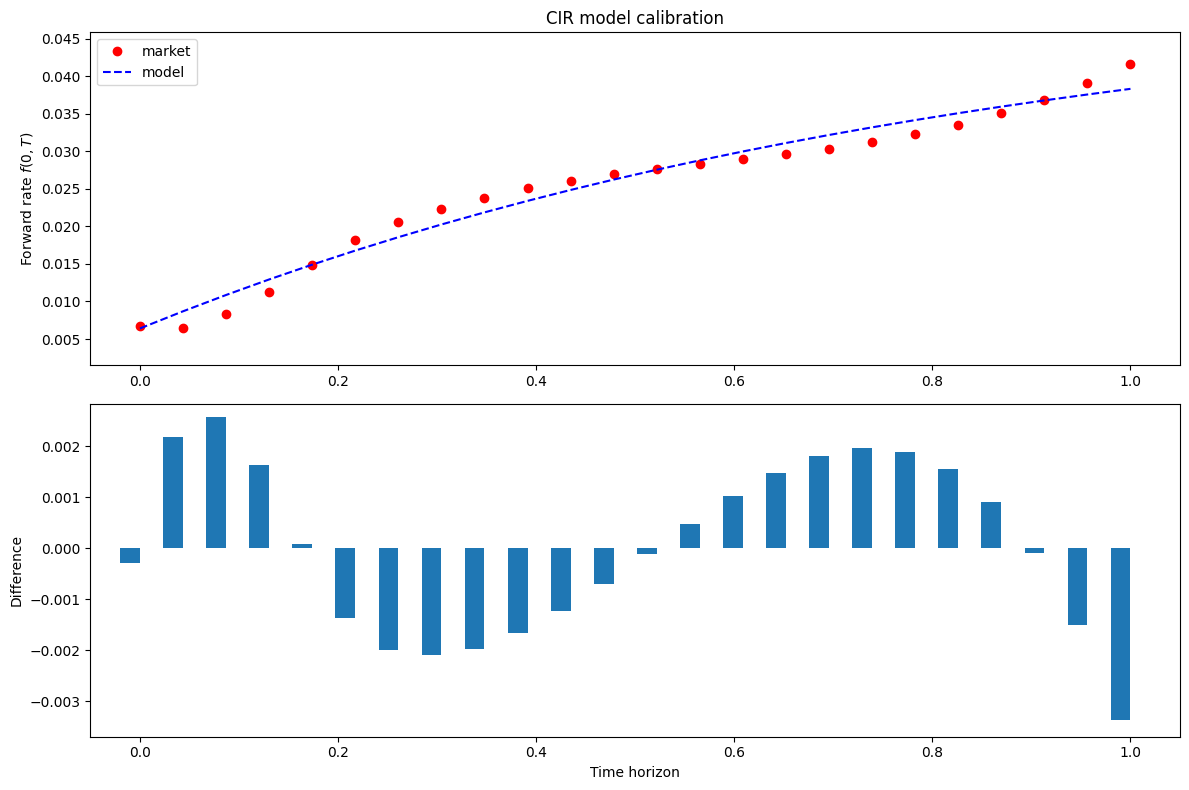

In [ ]:
plot_calibrated_frc(params)

We obtained the values

* $\kappa = 0.98908305$
* $\theta = 0.10863186$
* $\sigma = 0.0010074$

Here: $\kappa$ is the rate at which the interest rate reverts to the mean, $\theta$ is the long term mean interest rate, $\sigma$ is the volatility.

In [ ]:
params

array([0.98908305, 0.10863186, 0.00100074])

We perform a Monte Carlo simulation of the 12 month rate for the next 250 trading days; we calculate 100,000 different paths where each path is a simulation using the CIR stochastic differential equation of the 12-month Euribor rate.

In [ ]:
rates = cir(2.556/100, 0.98908305, 0.10863186, 0.00100074, 1, 250, 100000)

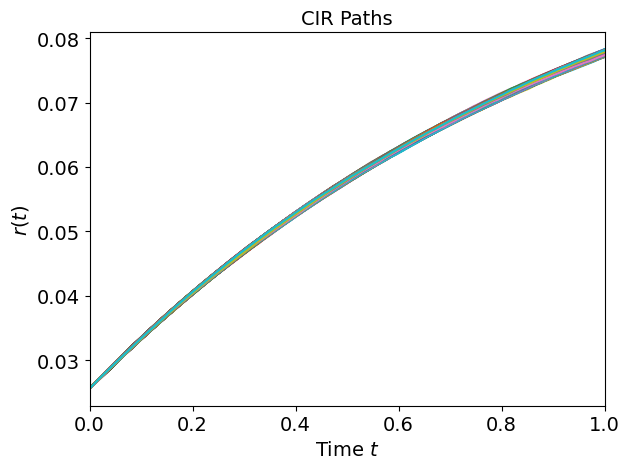

In [ ]:
for j in range(10000):
    plt.plot(np.linspace(0, 1, 250), rates[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, 1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

To find the expected value of the 12-month Euribor in 1 year, we can look at the values we get after one year in the various Monte Carlo paths, and take the average.

In [ ]:
np.mean(rates[-1])

0.07767427802154023

To get a confidence interval for the range that the 12-month Euribor takes over the next year, we can look at the minima and maxima over the various paths, and then look at the 99th percentile for each.

In [ ]:
maxima = np.max(rates, axis=0)
minima = np.min(rates, axis=0)

In [ ]:
np.percentile(maxima,99)

0.07806050875568603

In [ ]:
np.percentile(minima, 1)

0.02556

In [ ]:
np.percentile(rates[-1], 99)

0.07806050875568603

In [ ]:
np.percentile(rates[-1], 1)

0.07728384584380192


1.  It looks like at a 99% confidence rate, the 12-month Euribor rate will stay in the range (2.5%, 7.8%) over the next 12 months.  The 99% confidence interval for the rate 12 months from now is (7.72%, 7.81%)

2. The expected value for the Euribor rate in 1 year is 7.77%.

3. The expected value is higher than the current 12-month rate; rho is positive for calls and negative for puts, so we would expect the price of calls to increase and the price of puts to decrease.
